# Take Home Challenge

In [273]:
import pandas as pd
from pandas.core.window.rolling import Rolling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from datetime import date, timedelta
import matplotlib.dates as mdates
from matplotlib.dates import DateLocator, DateFormatter

## EDA

In [3]:
logs = pd.read_json('logins.json')

In [5]:
logs.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logs.describe()

/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_16142/3800066979.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  logs.describe()


,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [7]:
logs.isna().sum()

login_time    0
dtype: int64

In [8]:
logs.dtypes

login_time    datetime64[ns]
dtype: object

In [233]:
def resampler(freq):
    return logs.resample(freq, on='login_time').agg({'login_time':'count'}).rename({'login_time':'count'},axis=1).\
            reset_index()

In [262]:
def test_stationarity(timeseries, window, col):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()[col]
    rolstd = timeseries.rolling(window=window).std()[col]

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 7))
    original = plt.plot(timeseries['login_time'], timeseries[col], color='blue',label='Original', alpha=0.25)
    mean = plt.plot(timeseries['login_time'], rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries['login_time'], rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[col].iloc[1:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('Test statistic: ',dfoutput[0]) 
    print('Critical value: ',dfoutput[4])
    if dfoutput[0] > dfoutput[4]:
        print('Stationary')
    else:
        print('Non-stationary')
    print('if the Test Statistic:',dfoutput[0],'is greater than the Critical Value:', dfoutput[4], 'than the time series is stationary')

In [84]:
logs_15 = resampler('15Min')
logs_15.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [16]:
logs_15.shape

(9788, 7)

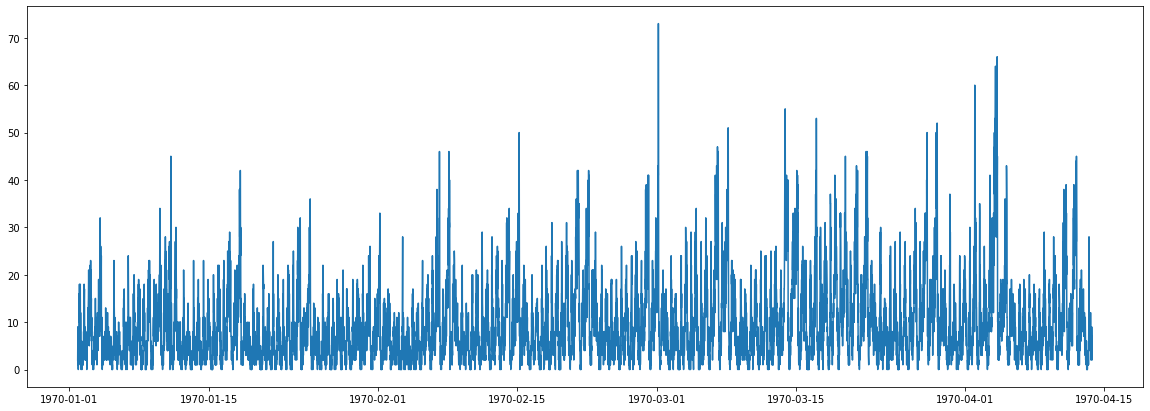

In [313]:
fig,ax = plt.subplots(figsize=(20,7))
ax.plot(logs_15.login_time, logs_15['count'])
plt.show()

In [319]:
# Trying to find daily trends
logs_daily = resampler('D')
logs_daily_select = logs_daily[logs_daily.login_time < '1970-02-15']

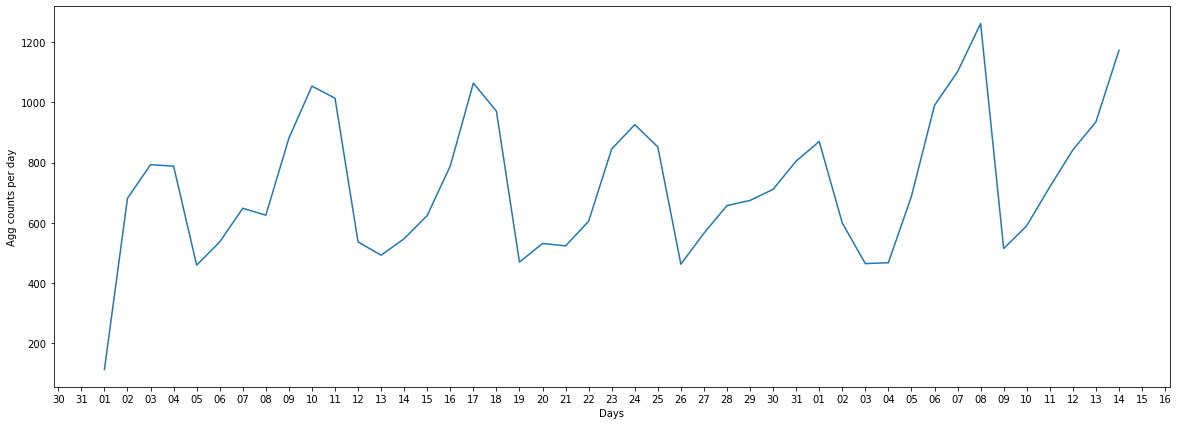

In [613]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(logs_daily_select['login_time'], logs_daily_select['count'])

date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.set_xlabel('Days')
ax.set_ylabel('Agg counts per day')
plt.show()

In [323]:
# By looking at the peaks, we can determine which days of the week are busiest and least-busy

mins = date(1970,1,5).strftime('%a'), date(1970,1,13).strftime('%a'), date(1970,1,19).strftime('%a'),\
date(1970,1,26).strftime('%a'), date(1970,2,3).strftime('%a'), date(1970,2,9).strftime('%a')
print('Least busy days:',mins)

Least busy days: ('Mon', 'Tue', 'Mon', 'Mon', 'Tue', 'Mon')


In [322]:
maxs = date(1970,1,3).strftime('%a'), date(1970,1,17).strftime('%a'), date(1970,1,24).strftime('%a'),\
date(1970,2,1).strftime('%a'), date(1970,2,8).strftime('%a')
print('Most busy days:',maxs)

Most busy days: ('Sat', 'Sat', 'Sat', 'Sun', 'Sun')


#### Saturdays and Sundays are most busy while Mondays and Tuesdays are least busy

## Stationarity

/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_16142/4119858775.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['login_time'], dtype='object')
  rolmean = timeseries.rolling(window=window).mean()[col]
/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_16142/4119858775.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['login_time'], dtype='object')
  rolstd = timeseries.rolling(window=window).std()[col]


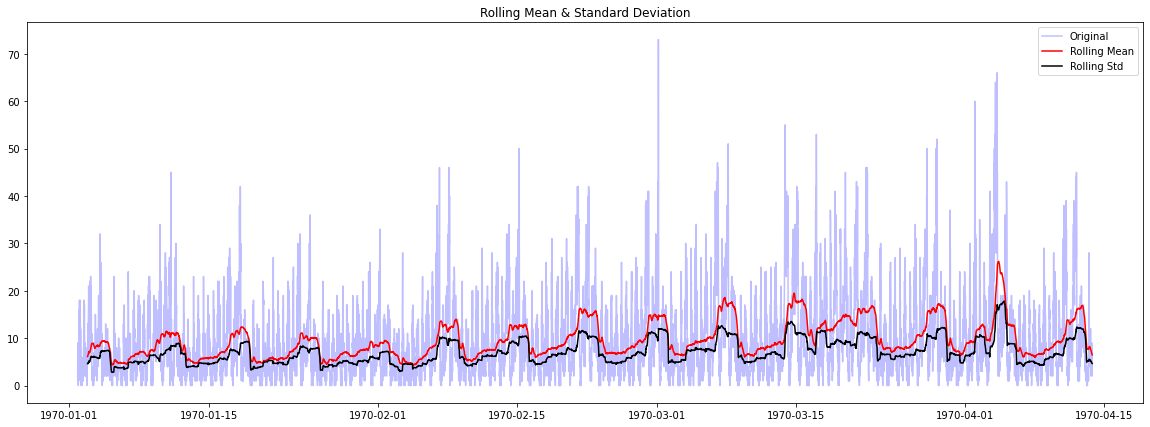

Results of Dickey-Fuller Test:
Test statistic:  -10.340737765830102
Critical value:  -3.431021011779871
Non-stationary
if the Test Statistic: -10.340737765830102 is greater than the Critical Value: -3.431021011779871 than the time series is stationary


In [324]:
test_stationarity(logs_15.dropna(), 96, 'count')

The data is not stationary

## Testing for autocorrelation

In [435]:
logs_hourly = resampler('H')
logs_daily = resampler('d')
logs_weekly = resampler('w')
logs_monthly = resampler('m')

logs_hourly.shape, logs_daily.shape, logs_weekly.shape, logs_monthly.shape

((2447, 2), (103, 2), (16, 2), (4, 2))

### Hourly

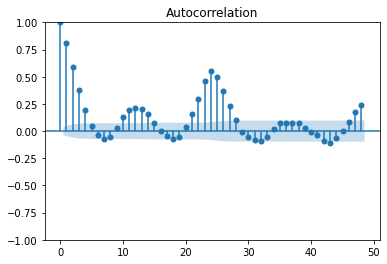

In [521]:
plot_acf(logs_hourly['count'], lags=48, alpha=0.05)
plt.show()

In [558]:
nlags = 48
ACF = acf(logs_hourly['count'], nlags=nlags)
lags = range(ACF.shape[0])


acf_list = pd.DataFrame({'Lags':lags, 'ACF':ACF})
acf_list[(acf_list.ACF > 0.1)]

,Lags,ACF
0,0,1.000000
1,1,0.809189
2,2,0.584965
3,3,0.376311
4,4,0.189867
10,10,0.132774
11,11,0.198067
12,12,0.216015
13,13,0.205167
14,14,0.160629


In [538]:
acf_list[acf_list.ACF < -0.05]

,Lags,ACF
7,7,-0.068540
8,8,-0.054872
18,18,-0.074634
19,19,-0.051540
30,30,-0.056925
31,31,-0.077632
32,32,-0.090244
33,33,-0.050506
42,42,-0.086960
43,43,-0.105471


There seems to be a positive autocorrelation at even multiples of 6 (12, 24, 36, 48). There are negative autocorrelations at odd multiples of 6 (18, 30, 42)

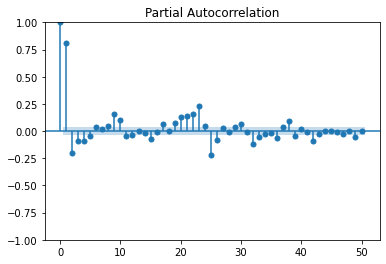

In [466]:
plot_pacf(logs_hourly['count'], method='ywm', lags=48, alpha=0.05)
plt.show()

In [559]:
nlags = 50
PACF = pacf(logs_hourly['count'], nlags=nlags, alpha=0.05)[0]
lags = range(PACF.shape[0])

pacf_list = pd.DataFrame({'Lags':lags, 'PACF':PACF})
pacf_list[(pacf_list.PACF > 0.1)]

,Lags,PACF
0,0,1.000000
1,1,0.809520
9,9,0.158348
10,10,0.104695
20,20,0.130124
21,21,0.140869
22,22,0.159209
23,23,0.232709


In [542]:
pacf_list[pacf_list.PACF < -0.1]

,Lags,PACF
2,2,-0.202736
25,25,-0.221526
32,32,-0.120501


### Daily/Weekly

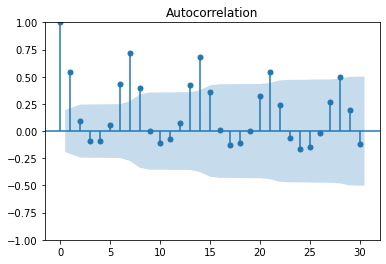

In [596]:
plot_acf(logs_daily['count'], lags=30, alpha=0.05)
plt.show()

In [598]:
nlags = 32
ACF = acf(logs_daily['count'], nlags=nlags)
lags = range(ACF.shape[0])

acf_list = pd.DataFrame({'Lags':lags, 'ACF':ACF})

In [599]:
acf_list[acf_list.ACF > 0.25]

,Lags,ACF
0,0,1.000000
1,1,0.543206
6,6,0.436453
7,7,0.722324
8,8,0.396365
13,13,0.422635
14,14,0.682466
15,15,0.357660
20,20,0.321428
21,21,0.546655


In [601]:
acf_list[acf_list.ACF < -0.1]

,Lags,ACF
10,10,-0.108800
17,17,-0.130163
18,18,-0.109983
24,24,-0.160755
25,25,-0.143418
30,30,-0.116645
31,31,-0.251539
32,32,-0.231420


The start of every week is positively correlated while the middle of each weak is negatively correlated

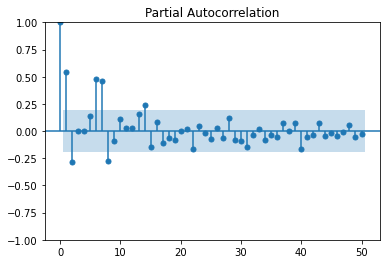

In [604]:
plot_pacf(logs_daily['count'], method='ywm', lags=50)
plt.show()

In [609]:
nlags = 50
PACF = pacf(logs_daily['count'], nlags=nlags, method='ywm')
lags = range(PACF.shape[0])

pacf_list = pd.DataFrame({'Lags':lags, 'PACF':PACF})

In [611]:
pacf_list[pacf_list.PACF > 0.2]

,Lags,PACF
0,0,1.000000
1,1,0.543206
6,6,0.483031
7,7,0.458572
14,14,0.236101


In [612]:
pacf_list[pacf_list.PACF < -0.1]

,Lags,PACF
2,2,-0.282885
8,8,-0.276263
15,15,-0.146825
17,17,-0.111543
22,22,-0.167432
31,31,-0.142624
40,40,-0.167066


### Monthly

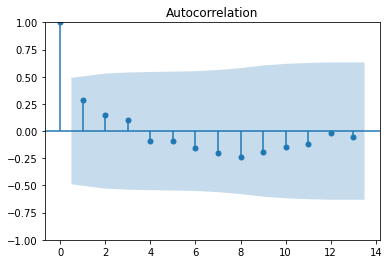

In [479]:
plot_acf(logs_weekly['count'])
plt.show()

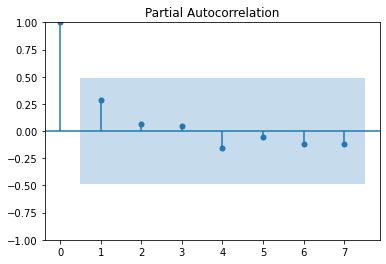

In [482]:
plot_pacf(logs_weekly['count'], method='ywm', lags=7)
plt.show()

There doesn't seem to be a monthly trend, there is no correlation between every 4th week